In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [71]:
reviews_df = pd.read_csv('../data/hotel_reviews.csv').drop('Unnamed: 0', axis=1)

reviews_df.columns = ['review', 'date']

In [72]:
reviews_df.head()

,review,date
0,Stayed for 7 nights with our 3 year old son. D...,02-Aug-18
1,We stayed in the Ali tower and had a very nice...,27-May-18
2,"Awesome place, attentive and friendly staff, s...",02-Aug-18
3,Had made a reservation in December to celebrat...,02-Aug-18
4,We arrived at the hotel at about 4:30pm local ...,02-Aug-18


To clean textual data, we call our custom 'clean_text' function that performs several transformations:

- lower the text.

- tokenize the text (split the text into words) and remove the punctuation.

- remove useless words that contain numbers.

- remove useless stop words like 'the', 'a' ,'this' etc.

- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database.

- lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep).

In [9]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)] #better using .isalpha()
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

CPU times: user 1min 16s, sys: 916 ms, total: 1min 17s
Wall time: 1min 17s


## Feature engineering

In [10]:
reviews_df.head()

,review,date,review_clean
0,Stayed for 7 nights with our 3 year old son. D...,02-Aug-18,stay night year old son decor hotel little old...
1,We stayed in the Ali tower and had a very nice...,27-May-18,stay ali tower nice stay proximity beach great...
2,"Awesome place, attentive and friendly staff, s...",02-Aug-18,awesome place attentive friendly staff stun vi...
3,Had made a reservation in December to celebrat...,02-Aug-18,make reservation december celebrate wedding an...
4,We arrived at the hotel at about 4:30pm local ...,02-Aug-18,arrive hotel local time hundred people check t...


In [40]:
reviews_df.review_clean[0]

'stay night year old son decor hotel little old run still neat tidy room quite large great amount activity restaurant resort location small trip away main area walkable would definitely recommend anyone child'

**First start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:**

- a neutrality score.

- a positivity score.

- a negativity score.

- an overall score that summarizes the previous scores.


We will integrate those 4 values as features in our dataset.

In [13]:
# add sentiment anaylsis columns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'] \
                        .apply(pd.Series)], axis=1)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abreualberto91/nltk_data...


In [14]:
reviews_df.head()

,review,date,review_clean,neg,neu,pos,compound
0,Stayed for 7 nights with our 3 year old son. D...,02-Aug-18,stay night year old son decor hotel little old...,0.000,0.747,0.253,0.9602
1,We stayed in the Ali tower and had a very nice...,27-May-18,stay ali tower nice stay proximity beach great...,0.015,0.744,0.241,0.9970
2,"Awesome place, attentive and friendly staff, s...",02-Aug-18,awesome place attentive friendly staff stun vi...,0.000,0.694,0.306,0.9306
3,Had made a reservation in December to celebrat...,02-Aug-18,make reservation december celebrate wedding an...,0.017,0.884,0.099,0.8720
4,We arrived at the hotel at about 4:30pm local ...,02-Aug-18,arrive hotel local time hundred people check t...,0.049,0.830,0.120,0.9408


**Next, we add some simple metrics for every text:**

- number of characters in the text.

- number of words in the text.

In [15]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [16]:
reviews_df.head()

,review,date,review_clean,neg,neu,pos,compound,nb_chars,nb_words
0,Stayed for 7 nights with our 3 year old son. D...,02-Aug-18,stay night year old son decor hotel little old...,0.000,0.747,0.253,0.9602,321,59
1,We stayed in the Ali tower and had a very nice...,27-May-18,stay ali tower nice stay proximity beach great...,0.015,0.744,0.241,0.9970,1302,251
2,"Awesome place, attentive and friendly staff, s...",02-Aug-18,awesome place attentive friendly staff stun vi...,0.000,0.694,0.306,0.9306,264,43
3,Had made a reservation in December to celebrat...,02-Aug-18,make reservation december celebrate wedding an...,0.017,0.884,0.099,0.8720,721,131
4,We arrived at the hotel at about 4:30pm local ...,02-Aug-18,arrive hotel local time hundred people check t...,0.049,0.830,0.120,0.9408,1014,189


**The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.**

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

First I have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, I can get those representation vectors.

In [17]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].\
                                                              apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)


In [19]:
reviews_df.head(2)

,review,date,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,Stayed for 7 nights with our 3 year old son. D...,02-Aug-18,stay night year old son decor hotel little old...,0.000,0.747,0.253,0.9602,321,59,0.041138,-0.244985,-0.089614,-0.026739,-0.087286
1,We stayed in the Ali tower and had a very nice...,27-May-18,stay ali tower nice stay proximity beach great...,0.015,0.744,0.241,0.9970,1302,251,0.416041,-0.412588,-0.216968,0.273688,-0.346135


**Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.**

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

- TF computes the classic number of times the word appears in the text.

- IDF computes the relative importance of this word which depends on how many texts the word can be found.

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [20]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index

reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [21]:
reviews_df.head(2)

,review,date,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yr,word_yrs,word_yuck,word_yum,word_yummy,word_zealand,word_zero,word_zip,word_zone,word_zoo
0,Stayed for 7 nights with our 3 year old son. D...,02-Aug-18,stay night year old son decor hotel little old...,0.000,0.747,0.253,0.9602,321,59,0.041138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,We stayed in the Ali tower and had a very nice...,27-May-18,stay ali tower nice stay proximity beach great...,0.015,0.744,0.241,0.9970,1302,251,0.416041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
tfidf_df.head()

,word_aaa,word_abandon,word_abc,word_ability,word_able,word_abound,word_about,word_absolute,word_absolutely,word_absurd,...,word_yr,word_yrs,word_yuck,word_yum,word_yummy,word_zealand,word_zero,word_zip,word_zone,word_zoo
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.073694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## WordCloud

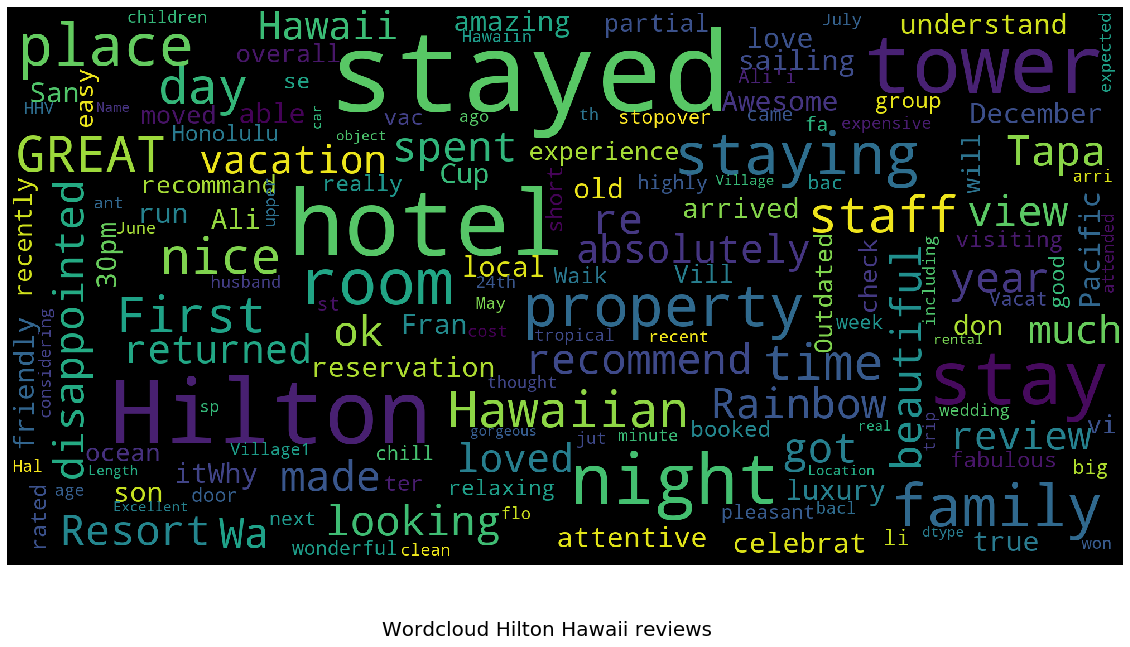

In [70]:
# wordcloud function
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = 'Wordcloud Hilton Hawaii reviews'):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 200,
        max_font_size = 40, 
        scale = 5,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

### Knowing the best and the words reviews

In [38]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
12700,"fabulous resort, fab location, rooms were great",0.724
11820,great view great service the staff was very ni...,0.705
11899,"Nice place, nice people, nice weather .... so ...",0.700
5445,Everything is amazing about this place!!! gorg...,0.640
1514,Great hotel. Enjoyed our stay. Friendly staff....,0.632
12123,great great place....beautiful beach...can't a...,0.621
3517,I loved it service was great. Rooms were clean...,0.615
12648,The hotel was super nice. The staff were so so...,0.614
2882,"Gorgeous property, super friendly employees an...",0.602
12865,Awesome place to stay and great for families.,0.577


In [39]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
9160,Extremely crowded. Definitely not a relaxing r...,0.374
8304,Crouded... Dirty Rooms... Dated room furniture...,0.351
10375,Valet parking is quite expensive and self park...,0.350
11014,I am not a fan of Waikiki Beach because I woul...,0.330
1744,HGV Suites in Kalia Tower fail to meet promise...,0.316
1526,Horrible experience checking in. Had to walk a...,0.306
10655,Horrible! Where is the aloha spirit here? EVER...,0.305
8610,Everything from the construction at the front ...,0.289
5379,"check in takes forever, not great value, food ...",0.281
3333,Great location but service is lacking. The roo...,0.279
